<a href="https://colab.research.google.com/github/max-dev-eng/ResearchPaperRepository/blob/main/Fig_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

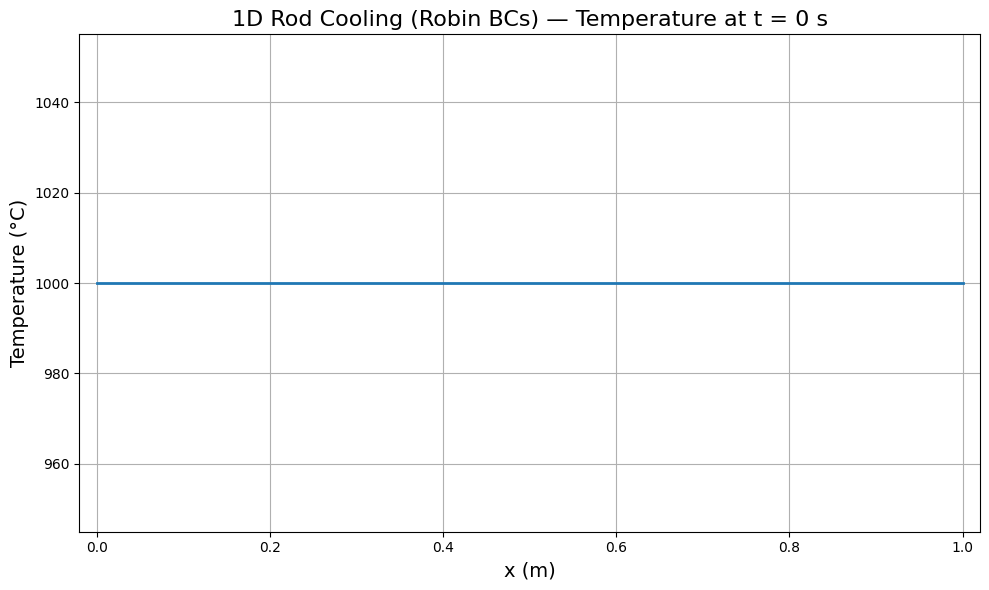

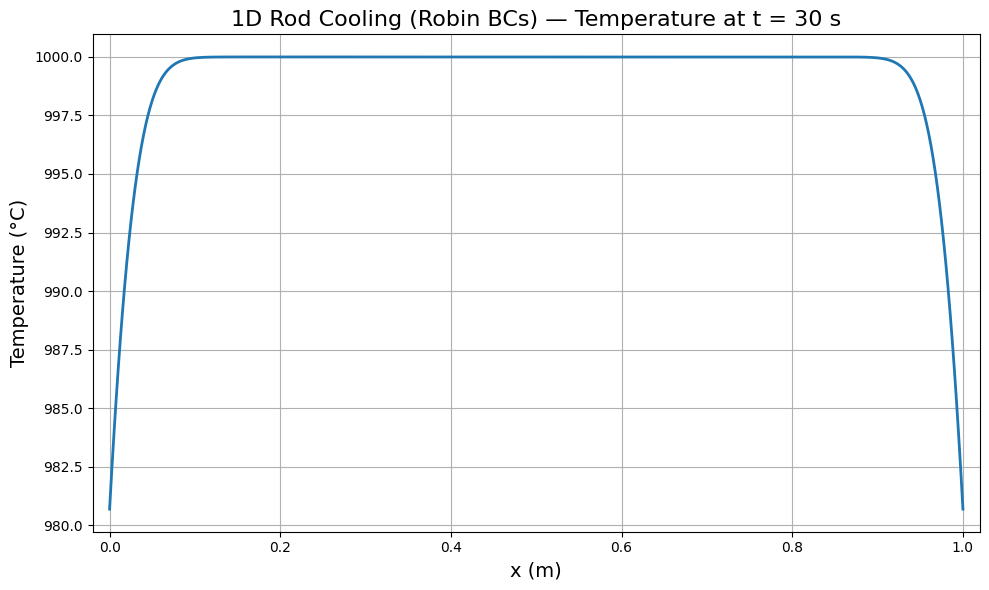

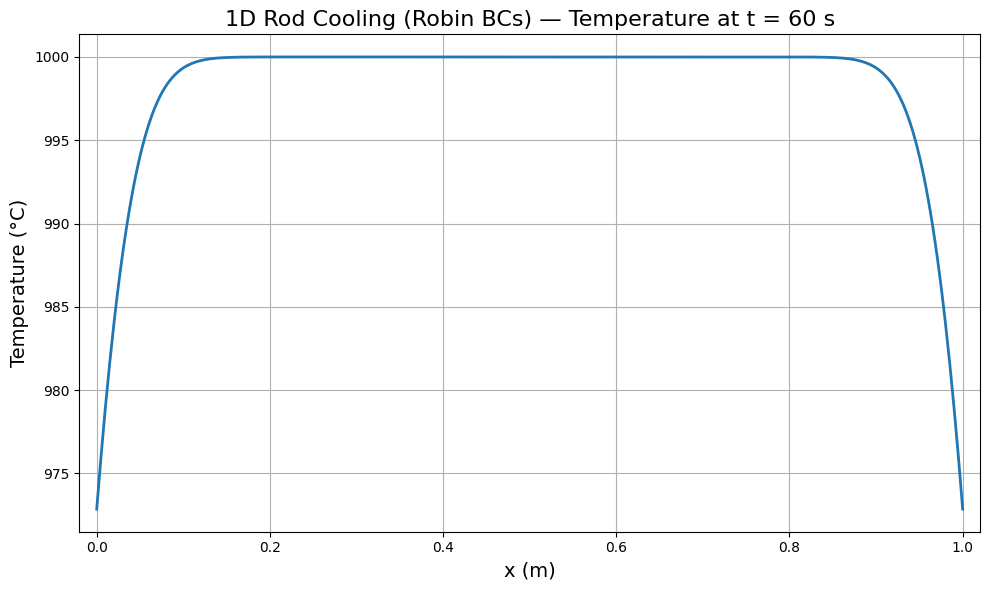

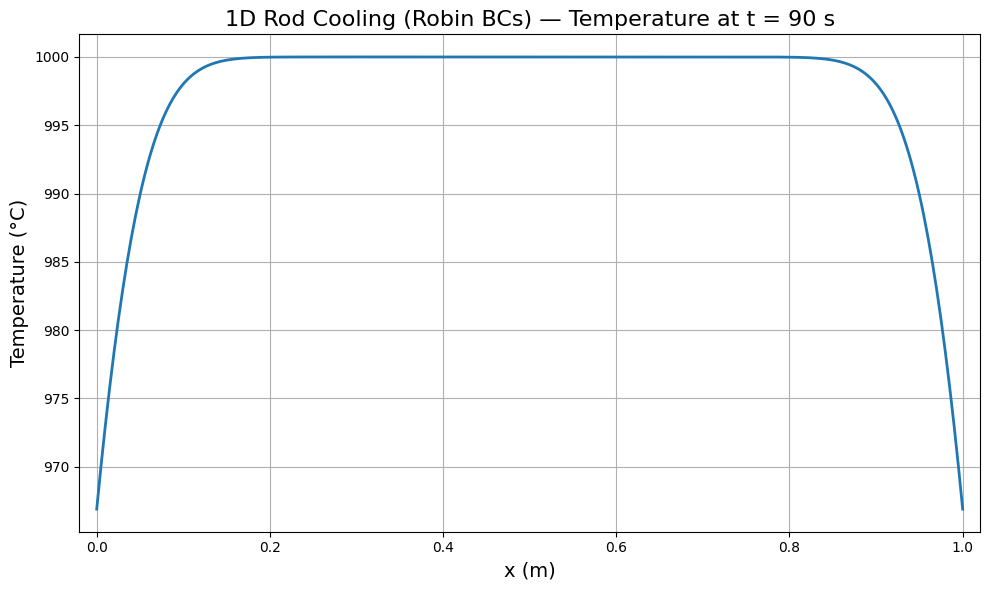

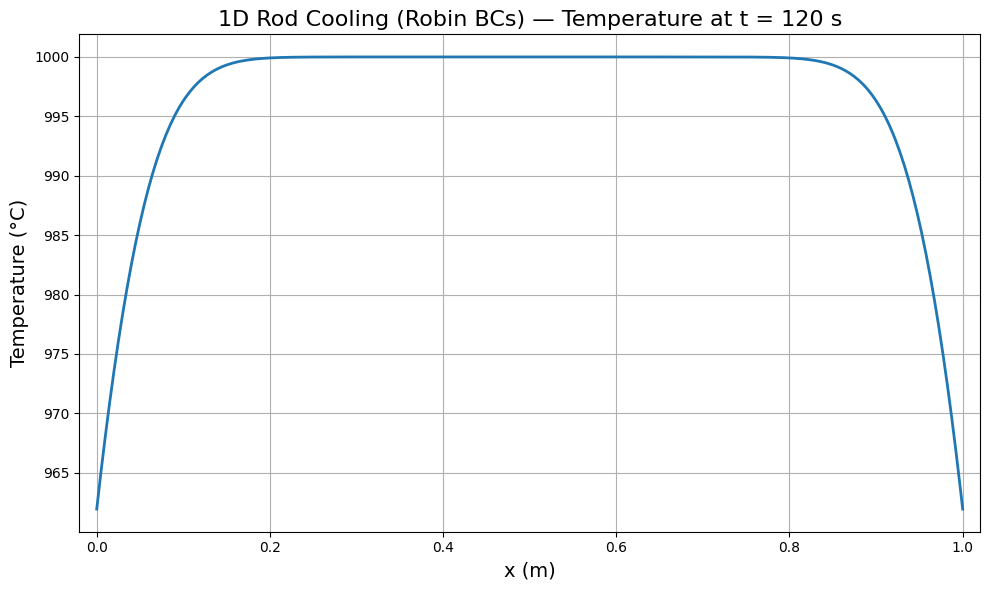

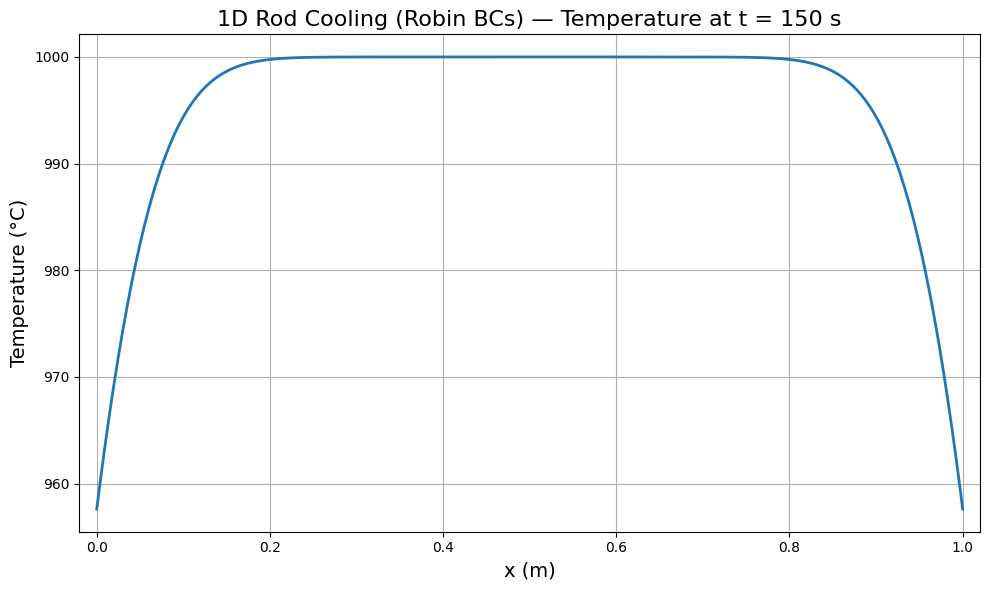

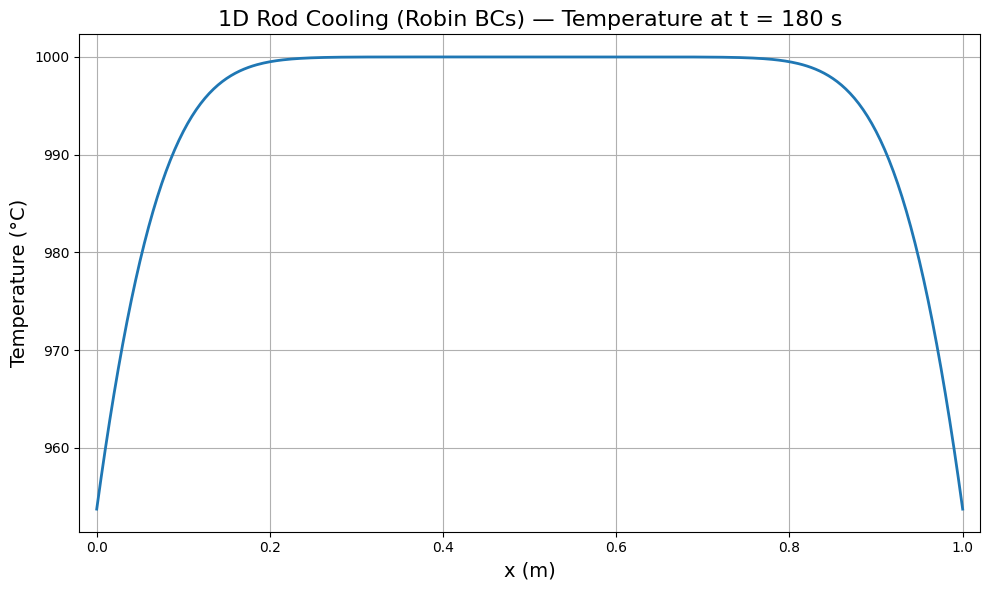

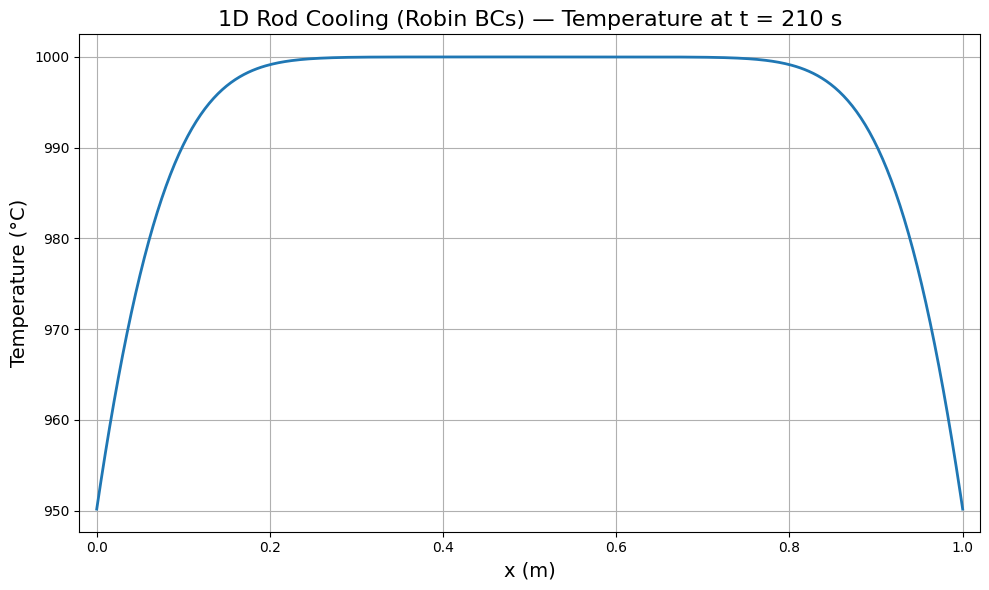

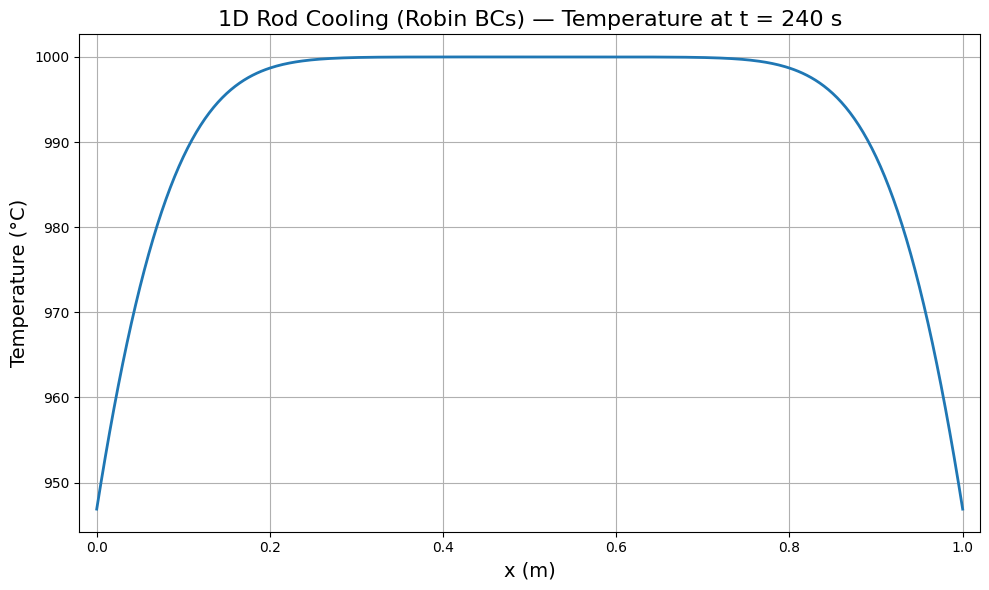

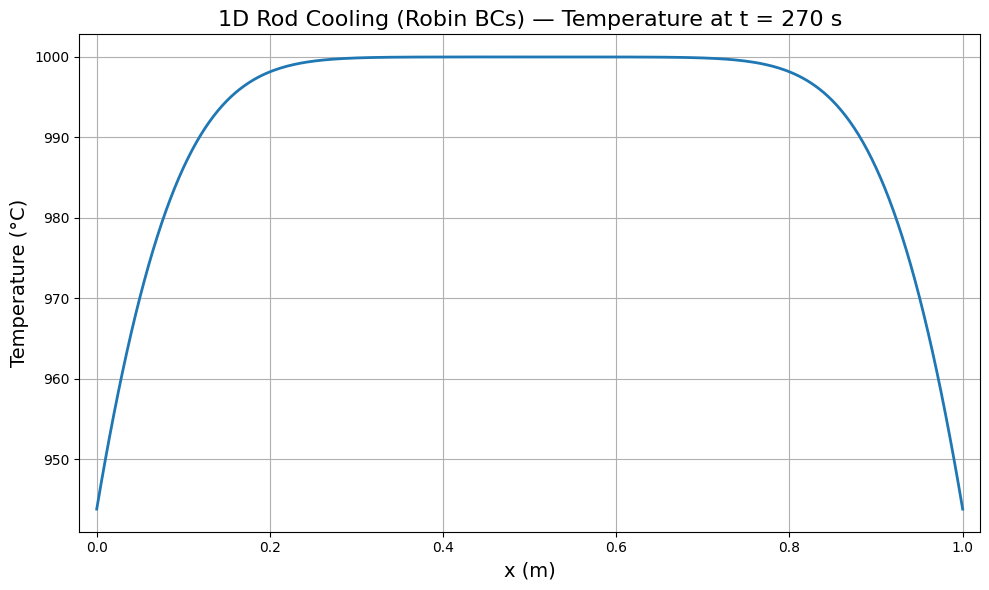

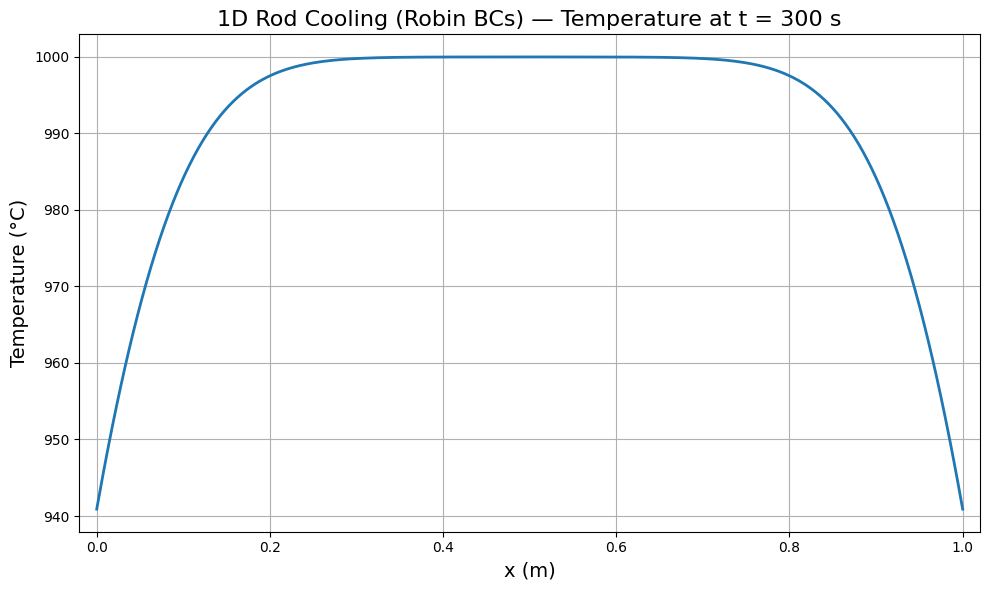

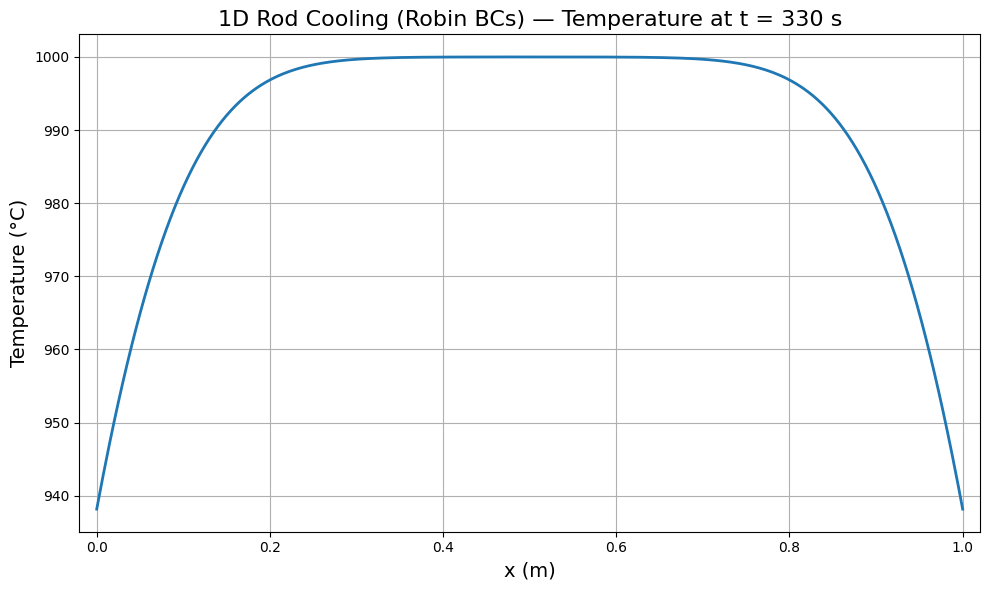

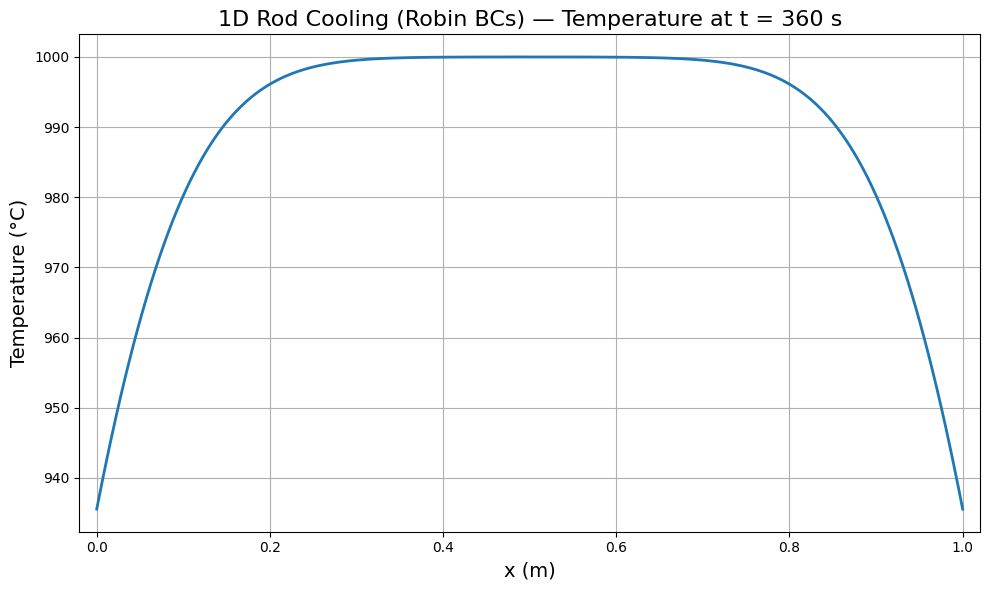

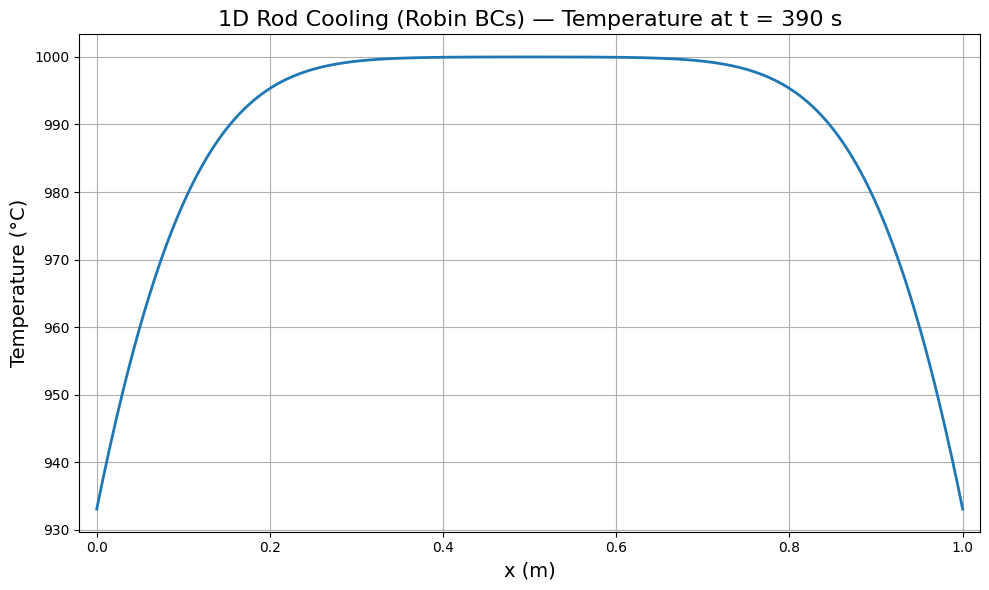

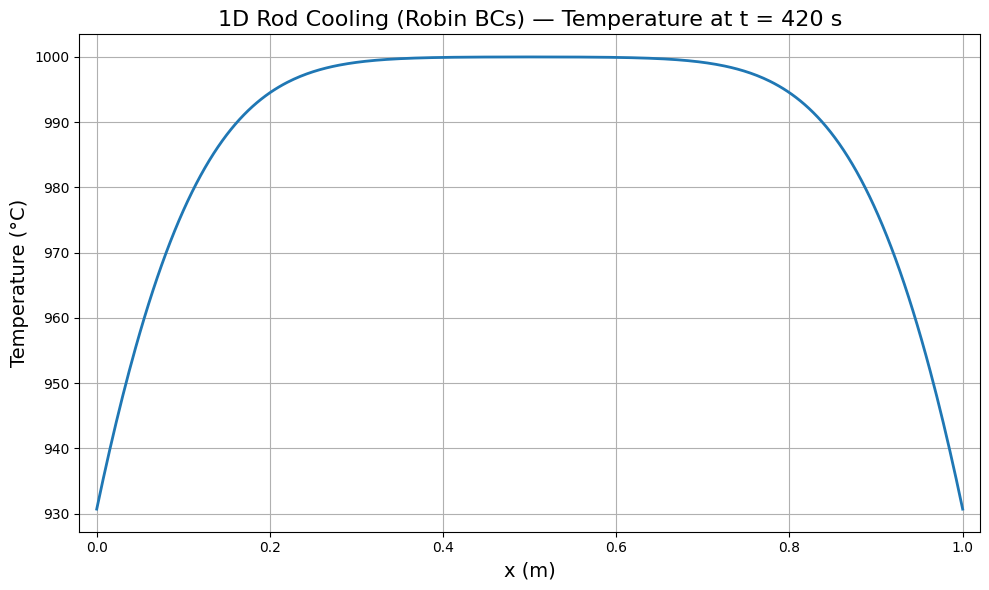

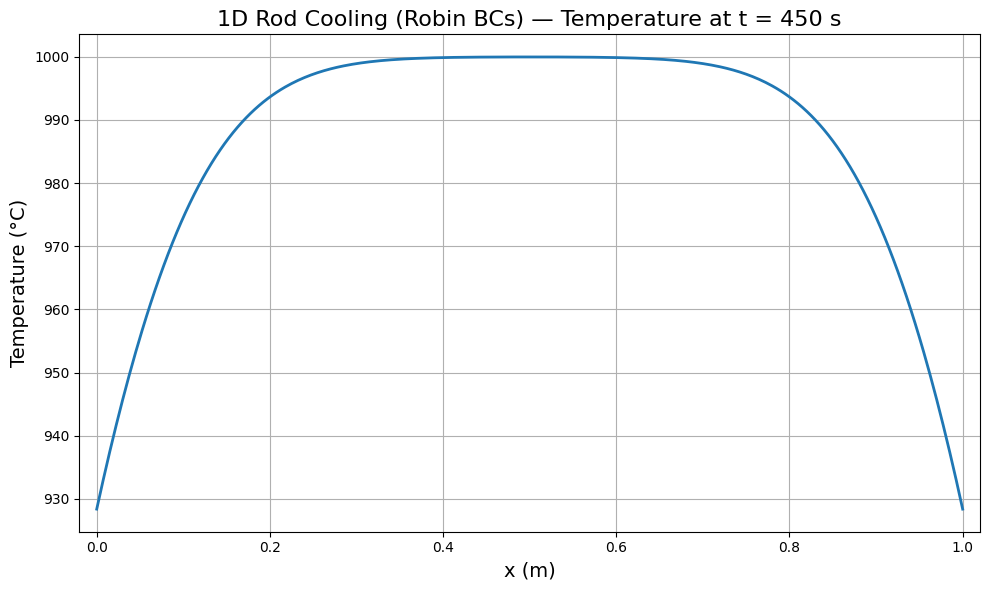

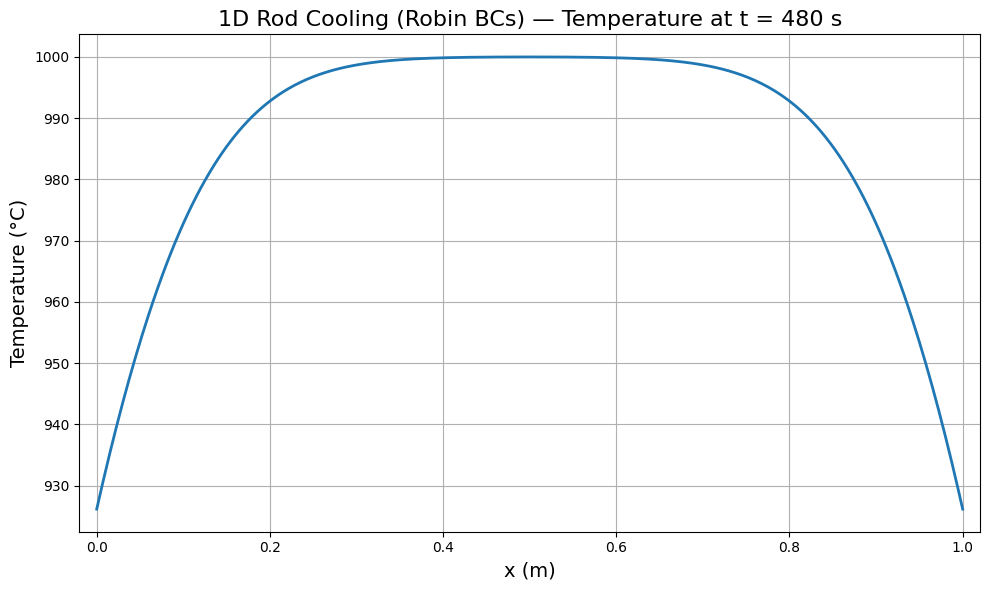

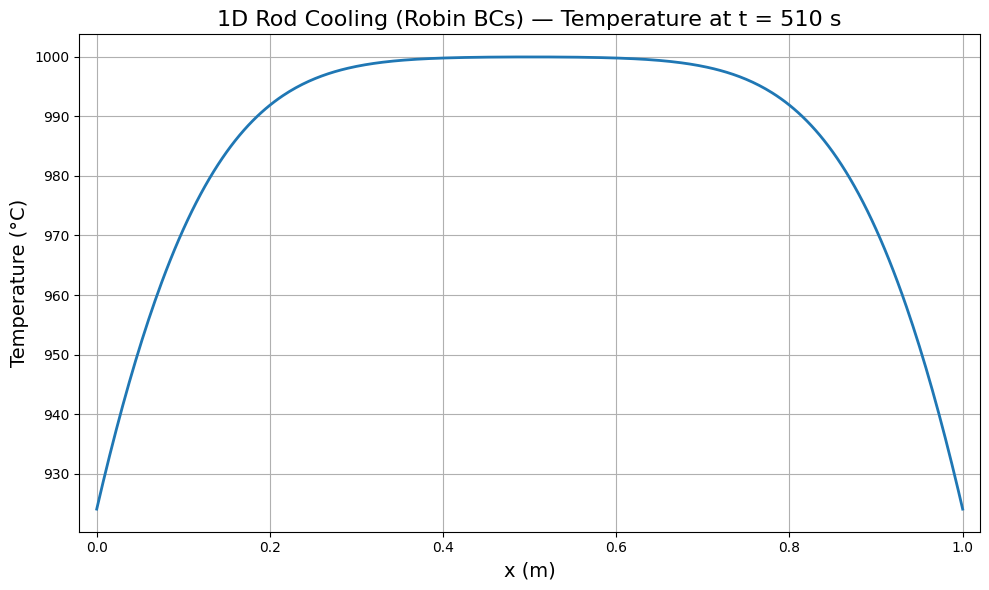

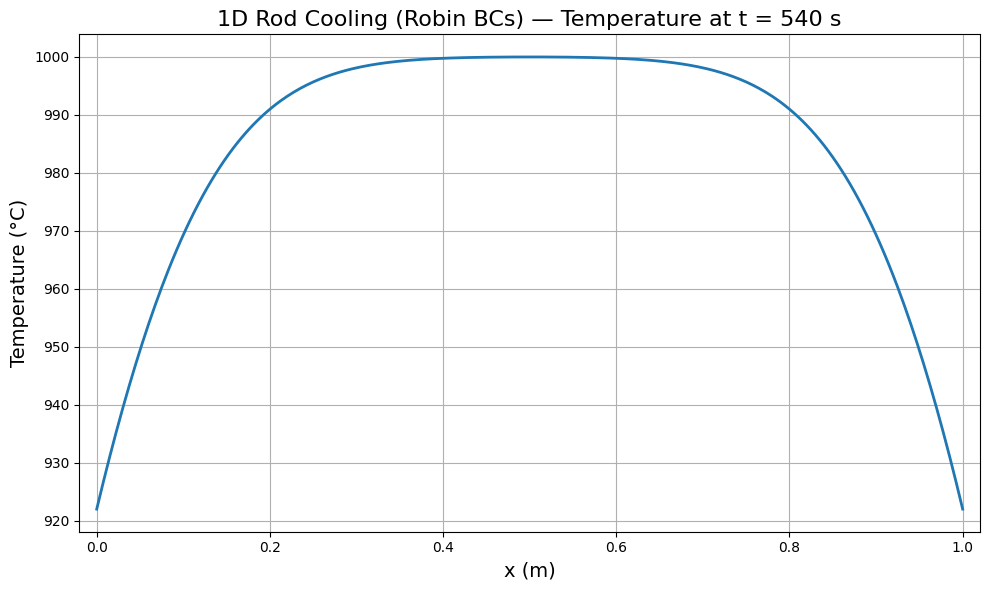

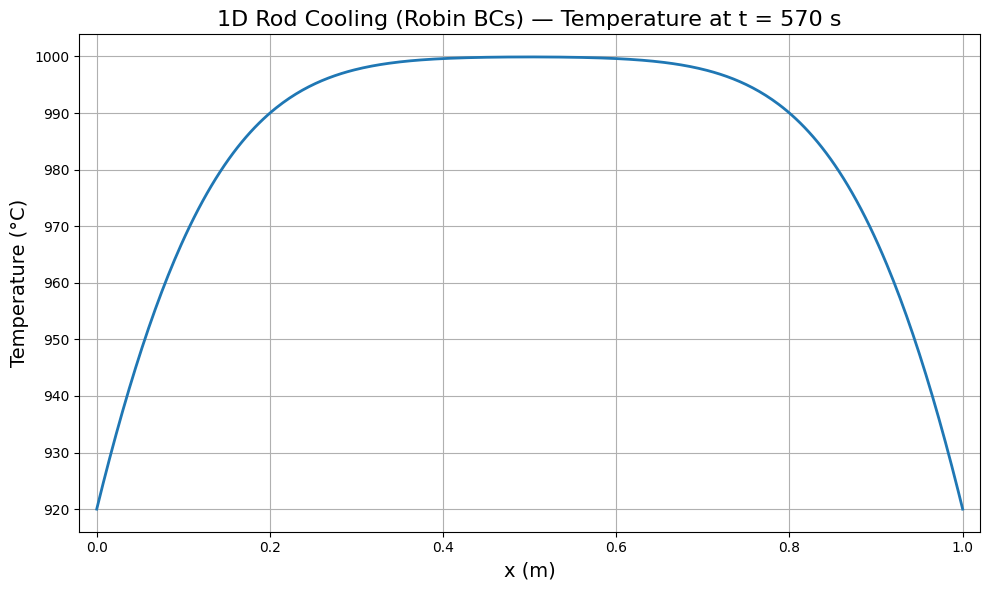

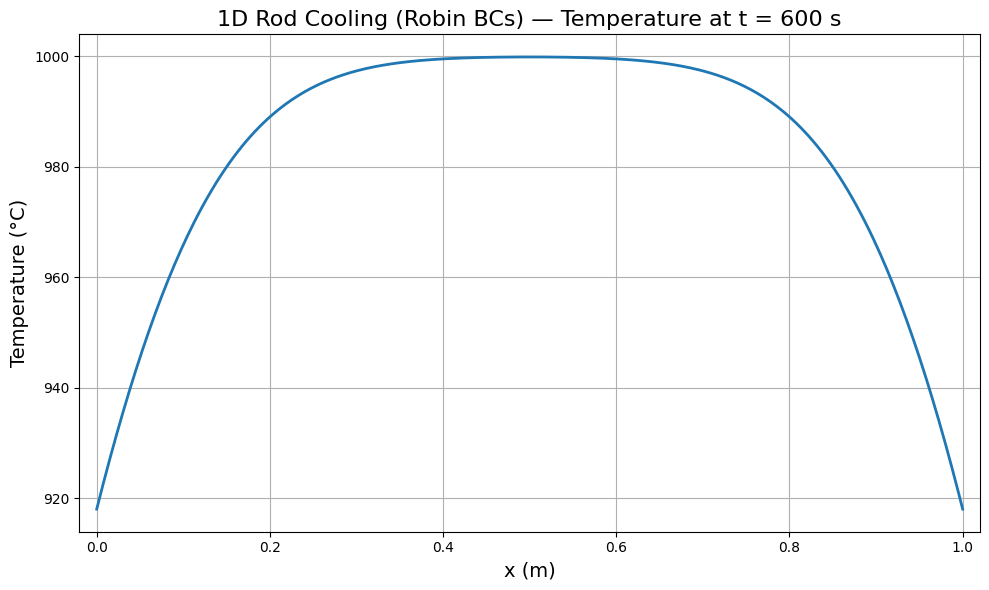

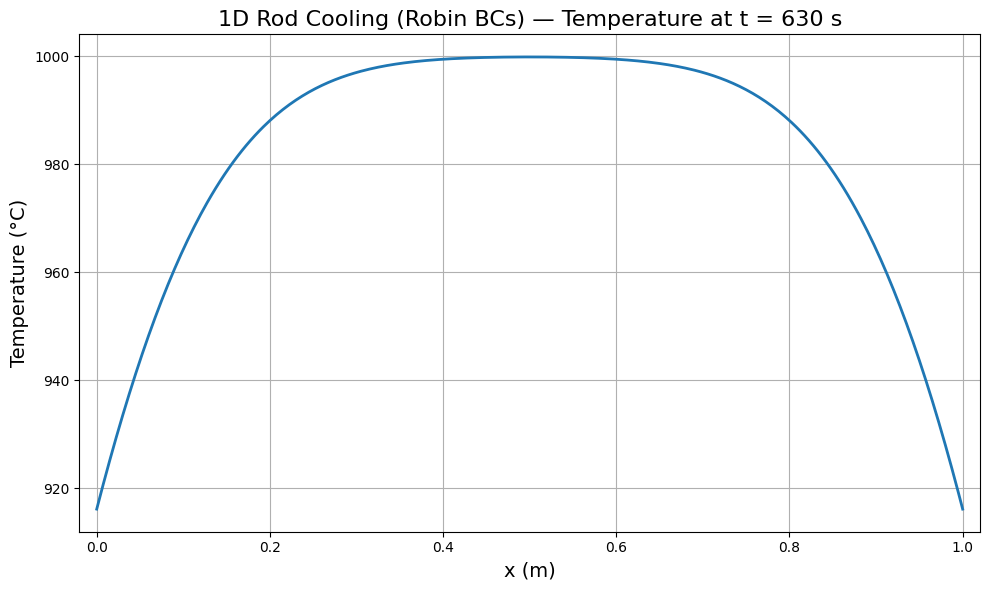

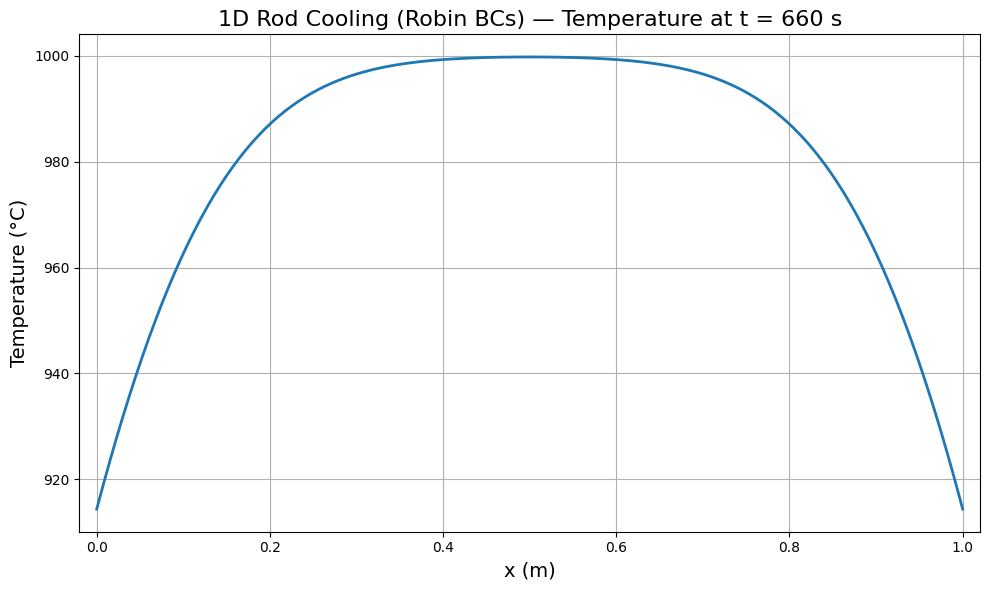

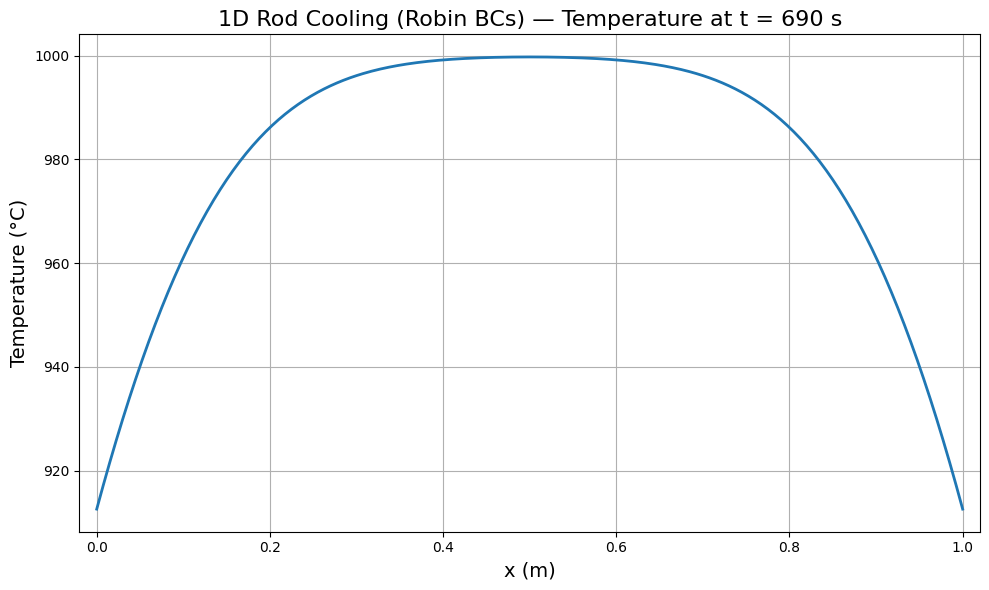

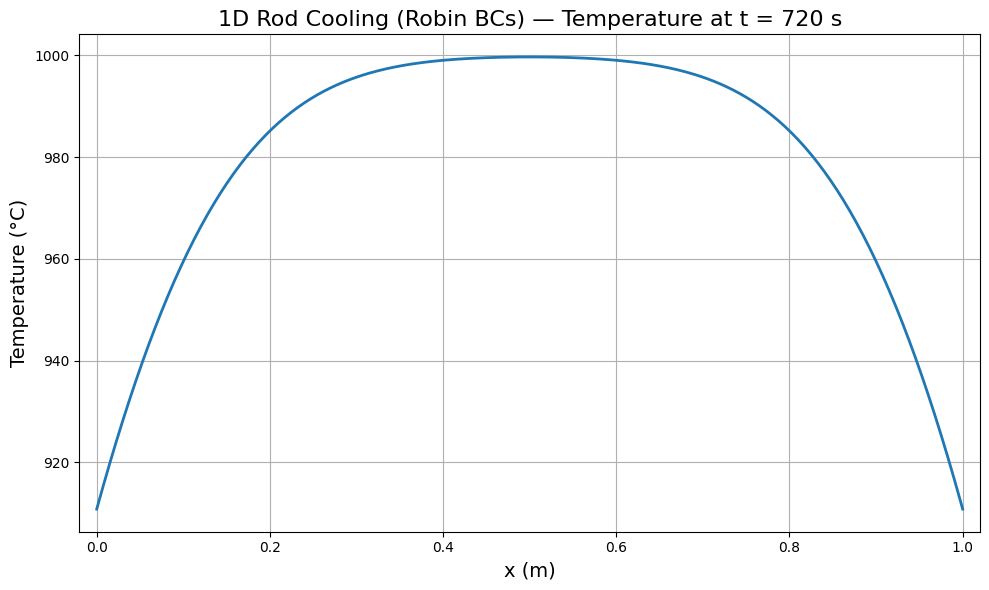

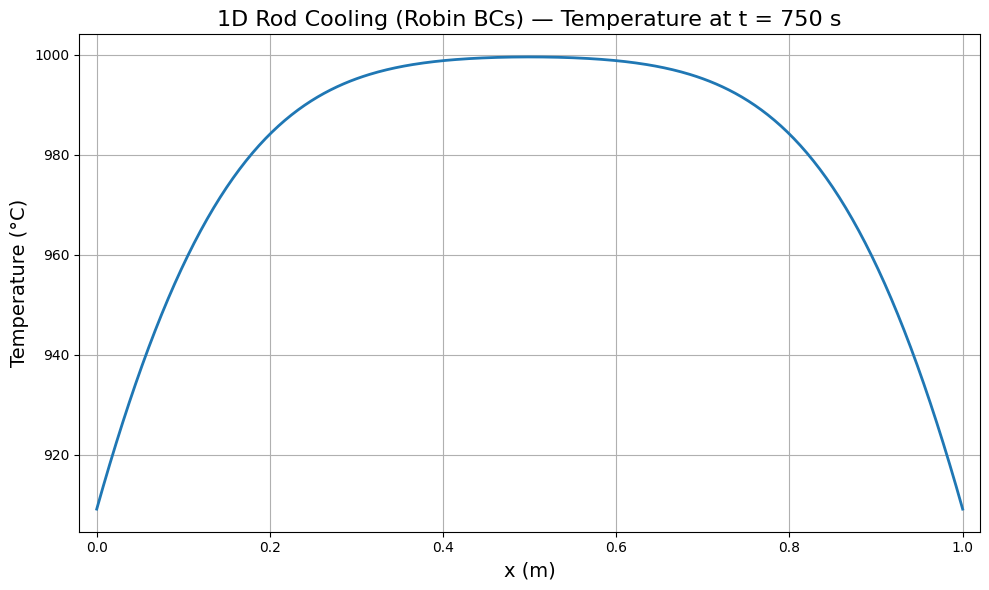

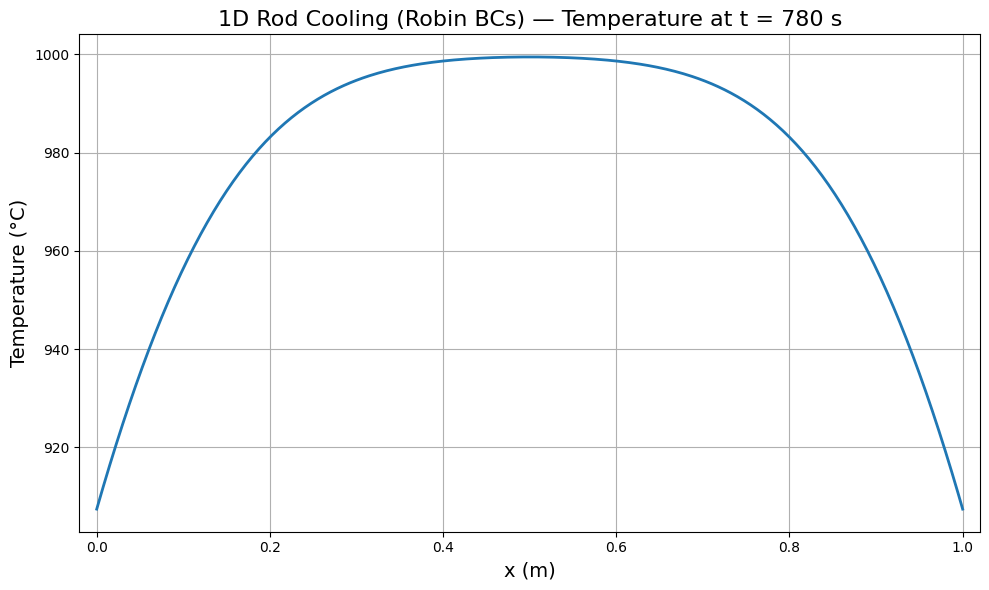

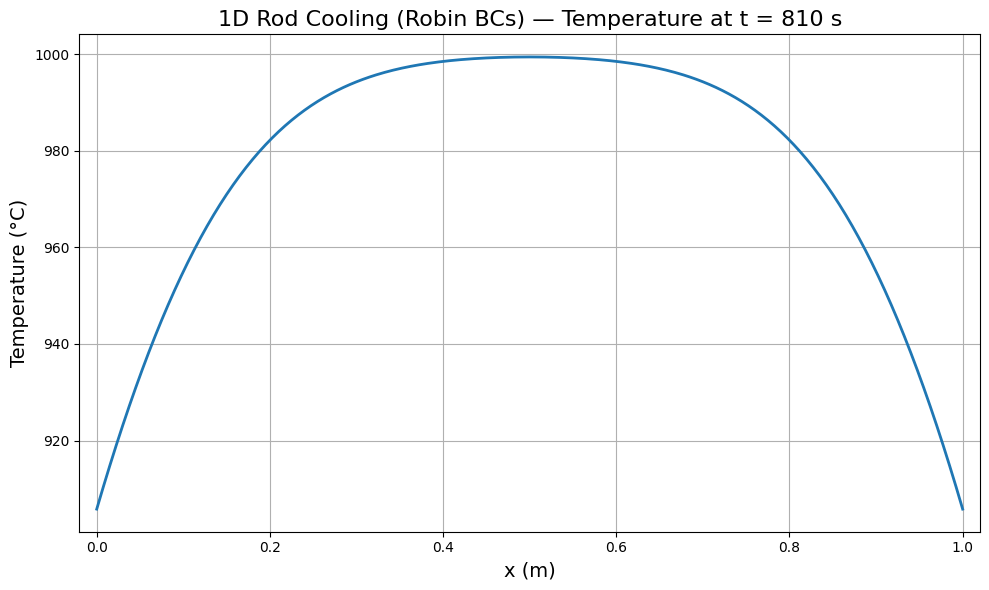

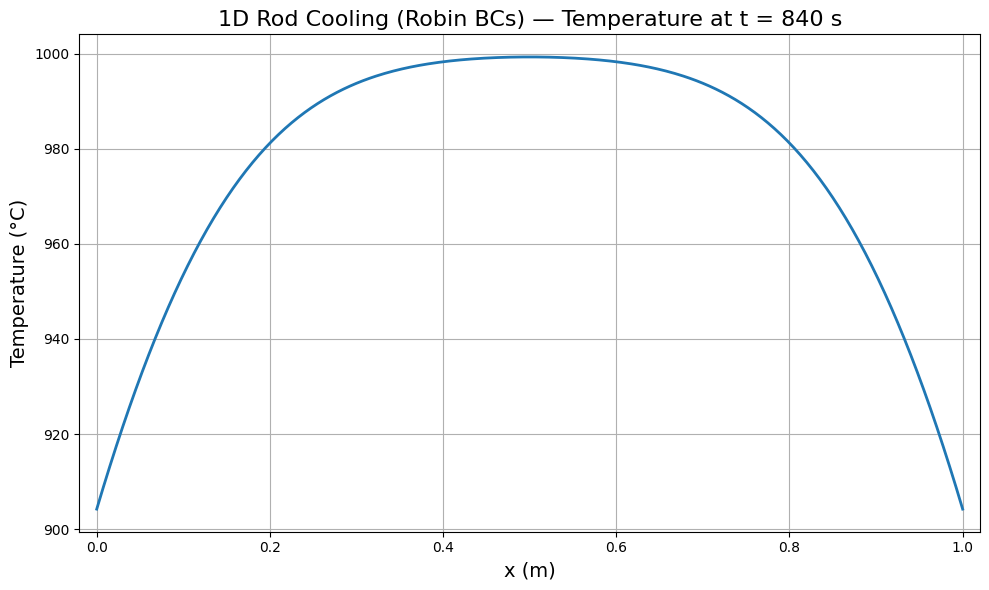

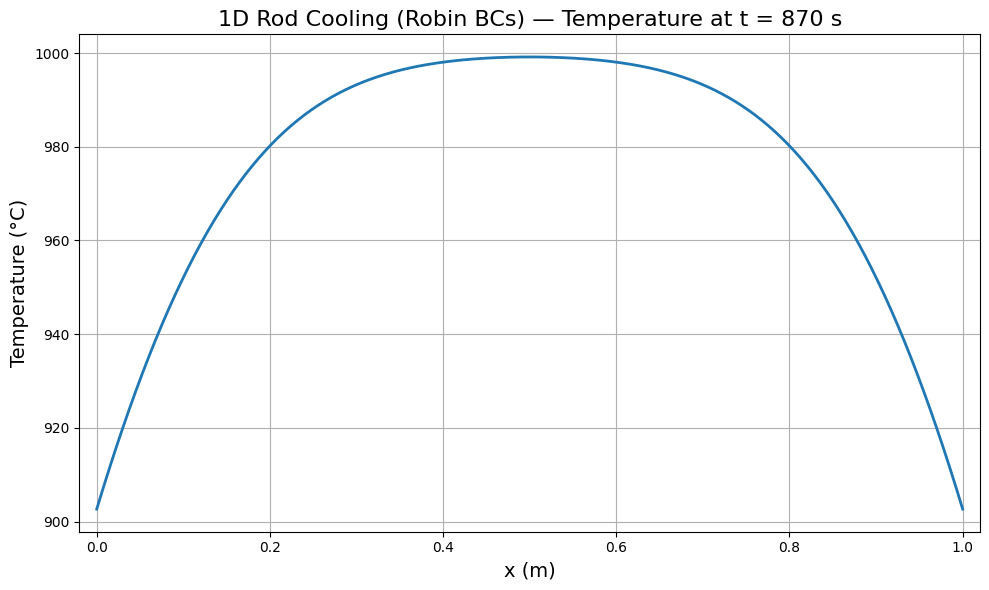

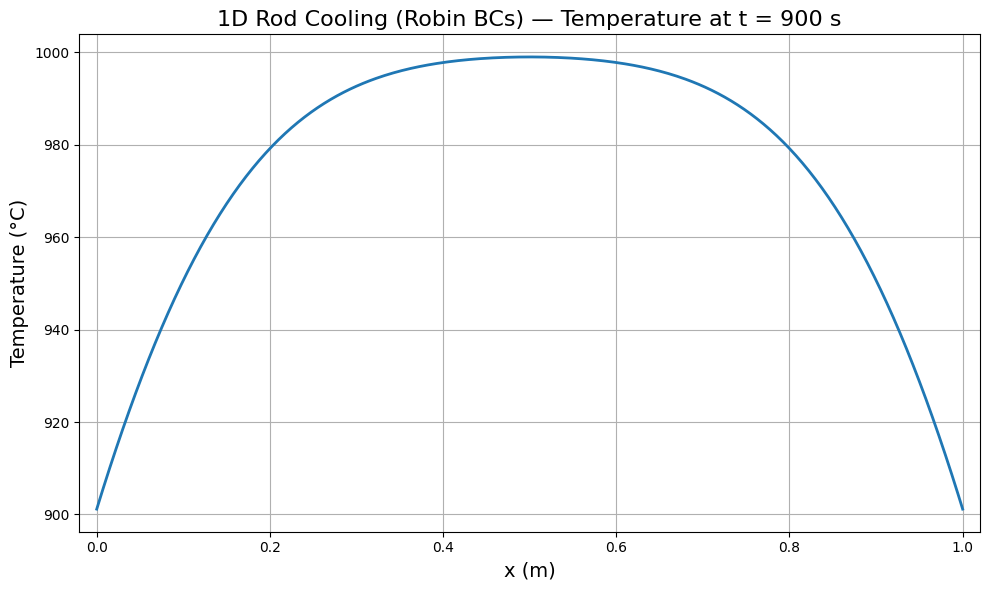

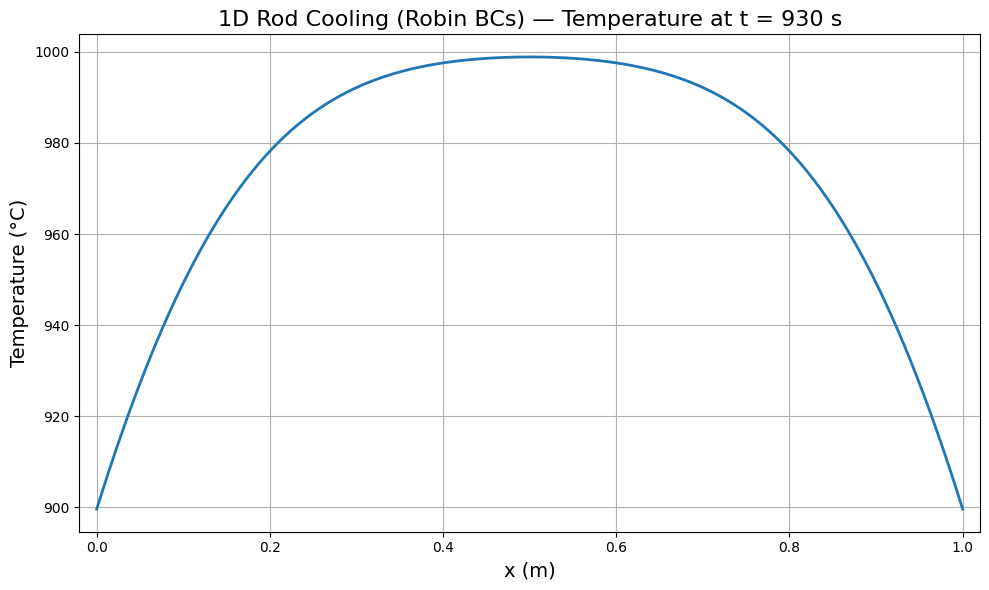

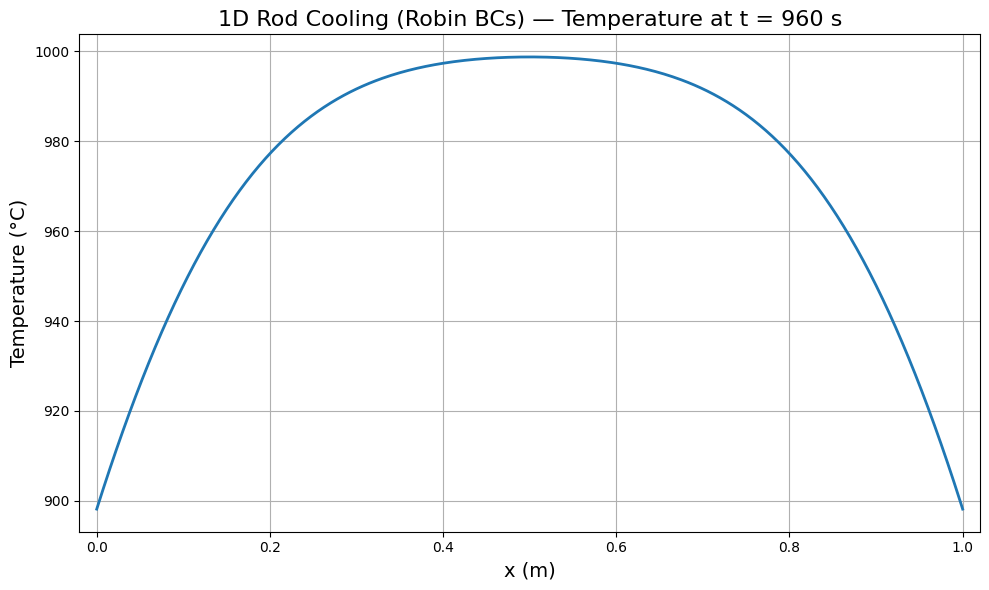

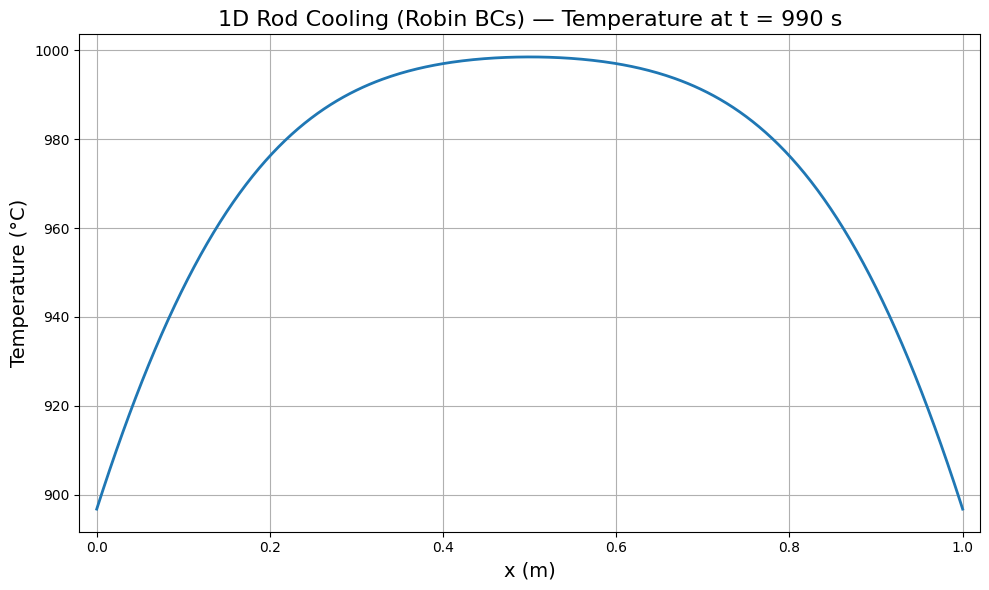

dt = 1.286550e-01 s, Nt = 7695, total time = 990.000000 s
T(0) at final time = 896.732 °C, T(L) at final time = 896.732 °C (should be symmetric)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1D HEAT EQUATION (COOLING ONLY) WITH ROBIN (CONVECTIVE) BCs
# rho cp dT/dt = d/dx ( k dT/dx )
# BCs:
#   at x=0:   k * dT/dx =  h (T - T_inf)
#   at x=L:  -k * dT/dx =  h (T - T_inf)
# =========================

# ---- Geometry / grid ----
L = 1.0
Nx = 401                      # increase for smoother boundary layers
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]

# ---- Carbon-carbon composite representative constants (kept constant for symmetry) ----
rho = 1780.0                  # kg/m^3
cp  = 2218.0                  # J/(kg·K)
k   = 86.3                    # W/(m·K)  (constant -> symmetric)
alpha = k / (rho * cp)

# ---- Convection (Robin) ----
T_inf = 23.0                  # °C ambient
h = 60.0                      # W/(m^2·K)

# ---- Initial condition (hotter than ambient) ----
T0 = 1000.0                    # °C
T = np.full(Nx, T0, dtype=float)

# ---- Times to save ----
save_times = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990]  # seconds
t_end = max(save_times)

# ---- Stability (explicit FTCS): r = alpha*dt/dx^2 <= 0.5 (use safety) ----
r_target = 0.45
dt = r_target * dx**2 / alpha
Nt = int(np.ceil(t_end / dt))
dt = t_end / Nt               # adjust so we hit t_end exactly

# Map each save time to the nearest step index (avoids KeyError from float mismatch)
save_steps = {int(round(ts / dt)): ts for ts in save_times}
save_steps[0] = 0             # ensure t=0 stored

snapshots = {0: T.copy()}

# ---- Time stepping ----
for n in range(1, Nt + 1):
    Tn = T.copy()

    # Ghost nodes from Robin BCs (2nd-order central gradient)
    # Left (x=0): k*(T1 - TghostL)/(2dx) = h*(T0 - T_inf)
    TghostL = Tn[1] - (2.0 * dx * h / k) * (Tn[0] - T_inf)

    # Right (x=L): -k*(TghostR - T_{N-2})/(2dx) = h*(T_{N-1} - T_inf)
    TghostR = Tn[-2] - (2.0 * dx * h / k) * (Tn[-1] - T_inf)

    # Interior FTCS update (constant k -> standard Laplacian)
    T[1:-1] = Tn[1:-1] + alpha * dt * (Tn[2:] - 2*Tn[1:-1] + Tn[:-2]) / dx**2

    # Boundary nodes using ghost values (keeps scheme symmetric)
    T[0]  = Tn[0]  + alpha * dt * (Tn[1] - 2*Tn[0]  + TghostL) / dx**2
    T[-1] = Tn[-1] + alpha * dt * (TghostR - 2*Tn[-1] + Tn[-2]) / dx**2

    if n in save_steps:
        snapshots[save_steps[n]] = T.copy()

# ---- Plot: 4 separate graphs (no markers, centred, no clipping) ----
for ts in save_times:
    Ti = snapshots[ts]
    plt.figure(figsize=(10, 6))
    plt.plot(x, Ti, linewidth=2)  # no markers -> no dots
    plt.title(f"1D Rod Cooling (Robin BCs) — Temperature at t = {ts} s", fontsize=16)
    plt.xlabel("x (m)", fontsize=14)
    plt.ylabel("Temperature (°C)", fontsize=14)

    # Center and prevent edge clipping
    plt.xlim(-0.02, L + 0.02)
    plt.margins(x=0.02, y=0.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print(f"dt = {dt:.6e} s, Nt = {Nt}, total time = {Nt*dt:.6f} s")
print(f"T(0) at final time = {T[0]:.3f} °C, T(L) at final time = {T[-1]:.3f} °C (should be symmetric)")